In [1]:
import sys
import os
sys.path.insert(0, os.path.dirname(os.getcwd()))
from config import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import time

from keras import backend as K

/Users/Quintus/anaconda3/envs/cobra_py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [41]:
import talos as ta

In [3]:
# standardization
# mean is computed only over the training data and then subtracted equally from all splits
scaler = StandardScaler().fit(X_train)
X_train = (X_train - scaler.mean_) / np.sqrt(scaler.var_)
X_test = (X_test - scaler.mean_) / np.sqrt(scaler.var_)

In [32]:
K.clear_session()
model = Sequential()
model.add(Dense(30, activation='relu', name="hidden_1", input_dim=X_train.shape[1]))
model.add(Dense(40, activation='relu', name="hidden_2"))
model.add(Dense(1, activation='sigmoid', name="op"))
model.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=80, batch_size=512, verbose=0)
roc_auc_score(y_test, model.predict_proba(X_test))

0.9418417133594978

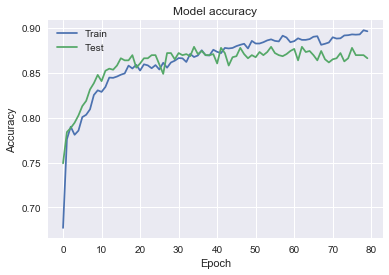

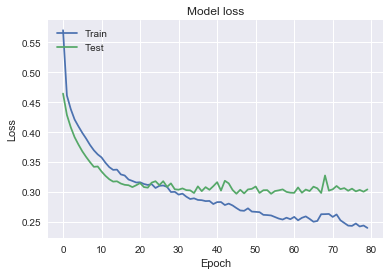

In [33]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
def learning_curve_nn(X, y, cv=None, train_size=None):
    lc_train = [] 
    lc_cv = []

    cut_points = np.round(train_size * X.shape[0]).astype(int)
    for cp in cut_points:
        X_sample = X.iloc[:cp]
        y_sample = y.iloc[:cp]
        train_scores = []
        cv_scores = []
        for train_idx, val_idx in cv.split(X_sample, y_sample):
            xtrain, xval = X_sample.iloc[train_idx], X_sample.iloc[val_idx]
            ytrain, yval = y_sample.iloc[train_idx], y_sample.iloc[val_idx]

            K.clear_session()
            model = Sequential()
            model.add(Dense(30, activation='relu', name="hidden_1", input_dim=X_train.shape[1]))
            model.add(Dense(40, activation='relu', name="hidden_2"))
            model.add(Dense(40, activation='relu', name="hidden_3"))
            model.add(Dense(1, activation='sigmoid', name="op"))
            model.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy')
            history = model.fit(xtrain, ytrain, epochs=60, batch_size=512, shuffle=True, verbose=0)
            
            fold_train_score = roc_auc_score(ytrain, model.predict_proba(xtrain))
            fold_cv_score = roc_auc_score(yval, model.predict_proba(xval))

            train_scores.append(fold_train_score)
            cv_scores.append(fold_cv_score)

        lc_train.append(train_scores)
        lc_cv.append(cv_scores)
    return train_size, np.array(lc_train), np.array(lc_cv)

In [28]:
def plot_learning_curve_nn(title, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel('roc_auc_score')

    train_sizes, train_scores, test_scores = learning_curve_nn(X, y, cv=cv, train_size=train_sizes)
    
    print(train_scores)
    print(test_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(linewidth=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [6]:
def validation_curve_layer_size(X, y, cv=None, param_range=None):
    lc_train = [] 
    lc_cv = []

    for cp in param_range:
        print(cp)
        train_scores = []
        cv_scores = []
        for train_idx, val_idx in cv.split(X, y):
            xtrain, xval = X.iloc[train_idx], X.iloc[val_idx]
            ytrain, yval = y.iloc[train_idx], y.iloc[val_idx]

            K.clear_session()
            model = Sequential()
            model.add(Dense(cp, activation='relu', name="hidden_1", input_dim=X_train.shape[1]))
            model.add(Dense(1, activation='sigmoid', name="op"))
            model.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy')
            history = model.fit(xtrain, ytrain, epochs=60, batch_size=512, shuffle=True, verbose=0)
            
            fold_train_score = roc_auc_score(ytrain, model.predict_proba(xtrain))
            fold_cv_score = roc_auc_score(yval, model.predict_proba(xval))

            train_scores.append(fold_train_score)
            cv_scores.append(fold_cv_score)

        lc_train.append(train_scores)
        lc_cv.append(cv_scores)
    return np.array(lc_train), np.array(lc_cv)

In [24]:
def validation_curve_num_of_layer(X, y, cv=None, param_range=None):
    lc_train = []
    lc_cv = []

    for cp in param_range:
        print(cp)
        train_scores = []
        cv_scores = []
        for train_idx, val_idx in cv.split(X, y):
            xtrain, xval = X.iloc[train_idx], X.iloc[val_idx]
            ytrain, yval = y.iloc[train_idx], y.iloc[val_idx]

            K.clear_session()
            model = Sequential()
            model.add(Dense(50, activation='relu', name="hidden_1", input_dim=X_train.shape[1]))
            for i in range(1, cp, 1):
                model.add(Dense(50, activation='relu', name=f"hidden_{i+1}"))
            model.add(Dense(1, activation='sigmoid', name="op"))
            model.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy')
            history = model.fit(xtrain, ytrain, epochs=60, batch_size=512, shuffle=True, verbose=0)
            
            fold_train_score = roc_auc_score(ytrain, model.predict_proba(xtrain))
            fold_cv_score = roc_auc_score(yval, model.predict_proba(xval))

            train_scores.append(fold_train_score)
            cv_scores.append(fold_cv_score)

        lc_train.append(train_scores)
        lc_cv.append(cv_scores)
    return np.array(lc_train), np.array(lc_cv)

In [18]:
def plot_validation_curve_nn(func, title, X, y, ylim=None, cv=None, param_name=None, param_range=None, log_scale=False):

    train_scores, test_scores = func(X, y, cv=cv, param_range=param_range)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('roc_auc_score')
    if ylim is not None:
        plt.ylim(*ylim)
    lw = 2

    if not log_scale:
        plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
        plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    else:
        plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
        plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    print(param_range[test_scores_mean.argmax()])
    return train_scores_mean, test_scores_mean

### Try a reasonable set of hps & Learning Curve

In [9]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

[[0.99663286 0.97192014 0.98099645 0.99326473 0.98074238 0.98802793
  0.98661457 0.99638857 0.98603259 0.99012641]
 [0.96573926 0.96080308 0.95644429 0.96066814 0.96986438 0.96827818
  0.96145744 0.96395313 0.96803241 0.96500788]
 [0.96713599 0.96744632 0.96565006 0.97069083 0.96634355 0.95875023
  0.96485375 0.96524662 0.96527572 0.96386572]
 [0.96352072 0.95603555 0.96164765 0.96399646 0.96212369 0.95112226
  0.95983152 0.96118757 0.96501475 0.9634961 ]
 [0.96393716 0.96221908 0.96375283 0.96490627 0.96994213 0.97244637
  0.96639992 0.96149812 0.96254951 0.96888208]]
[[0.86309524 0.87462687 0.87228261 0.8316129  0.91188811 0.86507937
  0.89880952 0.90895522 0.86210317 0.90964674]
 [0.89059267 0.91116751 0.90226095 0.91540453 0.89510007 0.89716049
  0.90826082 0.921051   0.91669648 0.88224638]
 [0.92196704 0.90905158 0.92020408 0.92306146 0.91460852 0.92682819
  0.91274321 0.90495912 0.91252643 0.92907984]
 [0.91987503 0.93916923 0.9344451  0.92324873 0.92893842 0.91377385
  0.9376467

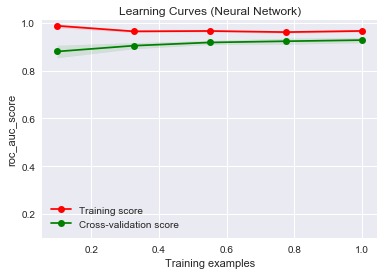

In [29]:
title = "Learning Curves (Neural Network)"
start = time.time()
plot_learning_curve_nn(title, X_train, y_train, ylim=(0.1, 1.01), cv=cv)
print(time.time() - start)

### Model Complexity Curve

93
237.76038002967834


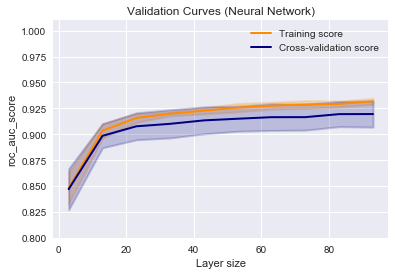

In [16]:
title = "Validation Curves (Neural Network)"

start = time.time()
plot_validation_curve_nn(validation_curve_layer_size, title, X_train, y_train, ylim=(0.8, 1.01), cv=cv, param_name='Layer size', param_range=range(3, 100, 10))
print(time.time() - start)
# 1 layer
# score increase as layer size increases

1
2
3
4
3
126.73203682899475


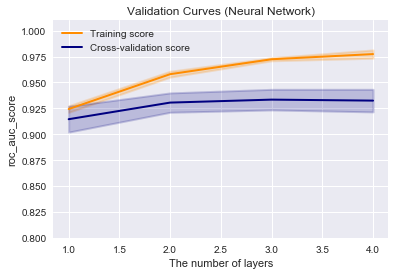

In [25]:
title = "Validation Curves (Neural Network)"

start = time.time()
plot_validation_curve_nn(validation_curve_num_of_layer, title, X_train, y_train, ylim=(0.8, 1.01), cv=cv, param_name='The number of layers', param_range=range(1, 5, 1))
print(time.time() - start)
# For nn with 1 hidden layer, when layer size is pretty large, adding more nodes is hard to improve performance, instead adding the number of layers could again improve performance
# But neural network with more layers tends to overfit

### Model Selection

In [56]:
def nn_model(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(Dense(int(params['first_neuron']), input_dim=x_train.shape[1], activation='relu'))
    model.add(Dropout(params['dropout']))
    
    # if we want to also test for number of layers and shapes, that's possible
#     hidden_layers(model, params, 1)
   
    # then we finish again with completely standard Keras way
    model.add(Dense(1, activation='sigmoid',
                    kernel_initializer='normal'))
    
    model.compile(loss='binary_crossentropy',
                  # here we add a regulizer normalization function from Talos
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], 'Adam')))
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0)
    
    # finally we have to make sure that history object and model are returned
    return history, model

In [ ]:
p = {'lr': (0.5, 5, 10),
     'first_neuron': [10],
     'hidden_layers':[0, 1, 2, 3, 4],
     'batch_size': [512],
     'epochs': [150],
     'dropout': (0, 0.5, 5),
     'optimizer': ['Adam', 'Nadam'],
     'losses': ['binary_crossentropy'],
     'activation':['relu'],
     'last_activation': ['sigmoid']
    }
t = ta.Scan(x=X_train.values,
            y=y_train.values,
            model=nn_model,
            val_split = 0.3,
            grid_downsample=0.1, 
            params=p,
            dataset_name='phoneme',
            experiment_no='1')

In [43]:
from talos.model.layers import hidden_layers